In [212]:

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import json
from collections import Counter
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from torch.optim import Adam
from torch.nn.functional import softmax
from torch import multinomial, tensor
import numpy as np
# GPU configuration

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [213]:
class LyricsDataset(Dataset):
    def __init__(self, text, seq_length=50):
        self.chars = sorted(set(text) | {'<unk>'})  # Ensure '<unk>' is part of the character set
        self.char_to_int = {ch: i for i, ch in enumerate(self.chars)}
        self.int_to_char = {i: ch for i, ch in enumerate(self.chars)}
        self.data = [self.char_to_int.get(ch, self.char_to_int['<unk>']) for ch in text]  # Use '<unk>' for unknown chars
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, index):
        return (
            torch.tensor(self.data[index:index+self.seq_length], dtype=torch.long),
            torch.tensor(self.data[index+1:index+self.seq_length+1], dtype=torch.long)
        )

# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim=256, hidden_dim=512, num_layers=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

    def forward(self, x, states):
        x = self.embedding(x)
        lstm_out, states = self.lstm(x, states)
        return self.fc(lstm_out), states

    def init_states(self, batch_size):
        return (
            torch.tensor([]).new_zeros(self.num_layers, batch_size, self.hidden_dim, device=device),
            torch.tensor([]).new_zeros(self.num_layers, batch_size, self.hidden_dim, device=device)
        )

In [214]:
def load__data(filepath):
    df = pd.read_parquet(filepath)
    return df['Lyrics_clean'].str.cat(sep=' ')

In [215]:
def train_model(model, dataloader, epochs=10, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    losses1, accuracies1 = [], []
    model.train()
    for epoch in range(epochs):
        total_loss, total_accuracy = 0, 0
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            states = model.init_states(inputs.size(0))
            outputs, states = model(inputs, states)
            outputs = outputs.transpose(1, 2)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)  # Get predictions from logits
            targets_flat = targets.view(-1)  # Flatten targets to align with predictions
            predicted_flat = predicted.view(-1)  # Flatten predictions to align with targets

            total_accuracy += (predicted_flat == targets_flat).float().mean().item()

        losses1.append(total_loss / len(dataloader))
        accuracies1.append(total_accuracy / len(dataloader))
        print(f'Epoch {epoch+1}, Loss: {losses1[-1]:.4f}, Accuracy: {accuracies1[-1]:.4f}')
    
    return losses1, accuracies1
        

In [216]:
def generate_lyrics2(model, start_str, int_to_char, char_to_int, total_length, diversity=0.8):
    model.eval()
    input_indices = [char_to_int.get(char, char_to_int['<unk>']) for char in start_str.lower()]  # Safely handle unknown chars
    input_tensor = torch.tensor([input_indices], dtype=torch.long).to(device)
    text = start_str
    states = model.init_states(1)

    for _ in range(total_length):
        output, states = model(input_tensor, states)
        output_div = output / diversity
        probabilities = softmax(output_div[:, -1, :], dim=1)
        char_id = multinomial(probabilities, 1).item()
        char = int_to_char[char_id]
        text += char
        input_tensor = torch.tensor([[char_id]], dtype=torch.long).to(device)

    return text


In [128]:
def generate_and_distribute_lyrics(model, start_str, int_to_char, char_to_int, total_length, diversities):
    lyrics_with_names = {}
    for diversity in diversities:
        extended_lyrics = generate_lyrics2(model, start_str, int_to_char, char_to_int, total_length, diversity)
        words = extended_lyrics.split()
        names = ["Harry", "Louis", "Zayn", "Niall", "Liam"]
        part_length = len(words) // len(names)
        parts = [words[i * part_length:(i + 1) * part_length] for i in range(len(names))]
        leftover = len(words) % len(names)
        if leftover:
            parts[-1].extend(words[-part_length - leftover:])
        formatted_text = ""
        for name, part in zip(names, parts):
            formatted_text += f"{name}:\n{' '.join(part)}\n\n"
        lyrics_with_names[diversity] = formatted_text

    return lyrics_with_names




In [217]:
import matplotlib.pyplot as plt
# Function to plot losses and accuracies
def plot_metrics(losses, accuracies, title="Training Metrics"):
    epochs = range(1, len(losses) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses, 'bo-', label='Loss')
    plt.title(title + ' - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracies, 'ro-', label='Accuracy')
    plt.title(title + ' - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Epoch 1, Loss: 0.7245, Accuracy: 0.7797
Epoch 2, Loss: 0.2607, Accuracy: 0.9164
Epoch 3, Loss: 0.2361, Accuracy: 0.9221
Epoch 4, Loss: 0.2264, Accuracy: 0.9243
Epoch 5, Loss: 0.2206, Accuracy: 0.9256
Epoch 6, Loss: 0.2163, Accuracy: 0.9265
Epoch 7, Loss: 0.2133, Accuracy: 0.9274
Epoch 8, Loss: 0.2109, Accuracy: 0.9278
Epoch 9, Loss: 0.2089, Accuracy: 0.9282
Epoch 10, Loss: 0.2074, Accuracy: 0.9284


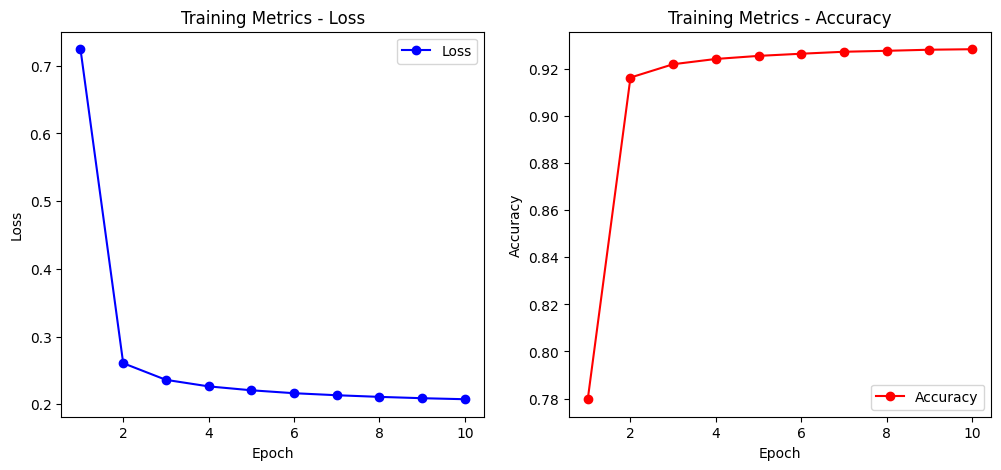

Model saved successfully.


In [218]:

    
lyrics_path = "C:\\Users\\Ananya\\anaconda3\\Dissertation - UL\\Music-Generation-with-AI-1\\Project\\data\\One_Direction_cleaned_lyrics.parquet"
model_save_path = "C:\\Users\\Ananya\\anaconda3\\Dissertation - UL\\Music-Generation-with-AI-1\\Project\\lstm_model_lyrics_generation.pth"

text_i = load__data(lyrics_path)
dataset = LyricsDataset(text_i)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

model = LSTMModel(len(dataset.char_to_int) + 1).to(device)
losses1, accuracies1 = train_model(model, dataloader, epochs=10, lr=0.001)


plot_metrics(losses1, accuracies1)
torch.save(model.state_dict(), model_save_path)
print("Model saved successfully.")

    

In [219]:
def save_lyrics(div, lyrics, filename="generated_lyrics.txt"):
    with open(filename, 'w') as file:
        file.write(lyrics)


In [220]:
user_input = input("Enter the starting words of the song: ")
diversities = [0.04, 0.1, 0.2, 0.5, 1.0, 1.2, 1.5]
final_lyrics = generate_and_distribute_lyrics(model, user_input, dataset.int_to_char, dataset.char_to_int, 500, diversities)

for div, lyrics in final_lyrics.items():
        save_lyrics(div, lyrics)
        print(f"Diversity {div}:\n{lyrics}\n")
        

Diversity 0.04:
Harry:
saw you in blue dress everything she never had she is showing off driving too fast moon is breaking through her

Louis:
hair she is heading for something that she will not forget having no regrets is all that she really wants ooh

Zayn:
we are only getting older and you have got that one thing get out get out get out of my head

Niall:
yeah and fall into my arms instead instead but i need that one thing i need that one thing i need

Liam:
that one thing and you have got that one thing get out get out get out of my head yeah and that one thing and you have got that one thing get out get out get out of my head yeah and fall into my arms



Diversity 0.1:
Harry:
saw you in blue dress everything she never had she is showing off driving too fast moon is breaking through her hair

Louis:
she is heading for something that she will not forget having no regrets is all that she really wants ooh we are

Zayn:
only getting older and you have got that one thing get out get ou

### with Oxford 3000


In [221]:
import matplotlib.pyplot as plt

def load_oxford_words(filepath):
    with open(filepath, 'r') as file:
        words = file.read().split()
    return ' '.join(words)  # Returning as a single string for easy combination

def load_combined_data(lyrics_path, oxford_path):
    lyrics = load__data(lyrics_path)
    oxford_words = load_oxford_words(oxford_path)
    combined_text = lyrics + ' ' + oxford_words
    return combined_text



In [222]:
def train_model2(model, dataloader, epochs=15, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    losses, accuracies = [], []
    
    model.train()
    for epoch in range(epochs):
        total_loss, total_accuracy = 0, 0
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            states = model.init_states(inputs.size(0))
            outputs, states = model(inputs, states)
            outputs = outputs.transpose(1, 2)  # Align outputs for loss calculation

            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

            # Accuracy calculation adjustments
            _, predicted = torch.max(outputs, 1)  # Get predictions from logits
            targets_flat = targets.view(-1)  # Flatten targets to align with predictions
            predicted_flat = predicted.view(-1)  # Flatten predictions to align with targets

            total_accuracy += (predicted_flat == targets_flat).float().mean().item()

        losses.append(total_loss / len(dataloader))
        accuracies.append(total_accuracy / len(dataloader))
        print(f'Epoch {epoch+1}, Loss: {losses[-1]:.4f}, Accuracy: {accuracies[-1]:.4f}')
    
    return losses, accuracies


In [223]:
# Function to plot losses and accuracies
def plot_metrics(losses, accuracies, title="Training Metrics"):
    epochs = range(1, len(losses) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses, 'bo-', label='Loss')
    plt.title(title + ' - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracies, 'ro-', label='Accuracy')
    plt.title(title + ' - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [224]:
def save_lyrics2(div, lyrics, filename="generated_lyrics_withOxford3000.txt"):
    with open(filename, 'w') as file:
        file.write(lyrics)

In [225]:
def generate_lyrics2(model, start_str, int_to_char, char_to_int, total_length, diversity=0.8):
    model.eval()
    input_indices = [char_to_int.get(char, char_to_int['<unk>']) for char in start_str.lower()]  # Safely handle unknown chars
    input_tensor = torch.tensor([input_indices], dtype=torch.long).to(device)
    text = start_str
    states = model.init_states(1)

    for _ in range(total_length):
        output, states = model(input_tensor, states)
        output_div = output / diversity
        probabilities = softmax(output_div[:, -1, :], dim=1)
        char_id = multinomial(probabilities, 1).item()
        char = int_to_char[char_id]
        text += char
        input_tensor = torch.tensor([[char_id]], dtype=torch.long).to(device)

    return text

In [226]:
def generate_and_distribute_lyrics(model, start_str, int_to_char, char_to_int, total_length, diversities):
    lyrics_with_names = {}
    for diversity in diversities:
        extended_lyrics = generate_lyrics2(model, start_str, int_to_char, char_to_int, total_length, diversity)
        words = extended_lyrics.split()
        names = ["Harry", "Louis", "Zayn", "Niall", "Liam"]
        part_length = len(words) // len(names)
        parts = [words[i * part_length:(i + 1) * part_length] for i in range(len(names))]
        leftover = len(words) % len(names)
        if leftover:
            parts[-1].extend(words[-part_length - leftover:])
        formatted_text = ""
        for name, part in zip(names, parts):
            formatted_text += f"{name}:\n{' '.join(part)}\n\n"
        lyrics_with_names[diversity] = formatted_text

    return lyrics_with_names

Epoch 1, Loss: 0.7531, Accuracy: 0.7693
Epoch 2, Loss: 0.2935, Accuracy: 0.9070
Epoch 3, Loss: 0.2677, Accuracy: 0.9138
Epoch 4, Loss: 0.2580, Accuracy: 0.9161
Epoch 5, Loss: 0.2525, Accuracy: 0.9175
Epoch 6, Loss: 0.2488, Accuracy: 0.9184
Epoch 7, Loss: 0.2466, Accuracy: 0.9189
Epoch 8, Loss: 0.2453, Accuracy: 0.9192
Epoch 9, Loss: 0.2446, Accuracy: 0.9193
Epoch 10, Loss: 0.2445, Accuracy: 0.9192


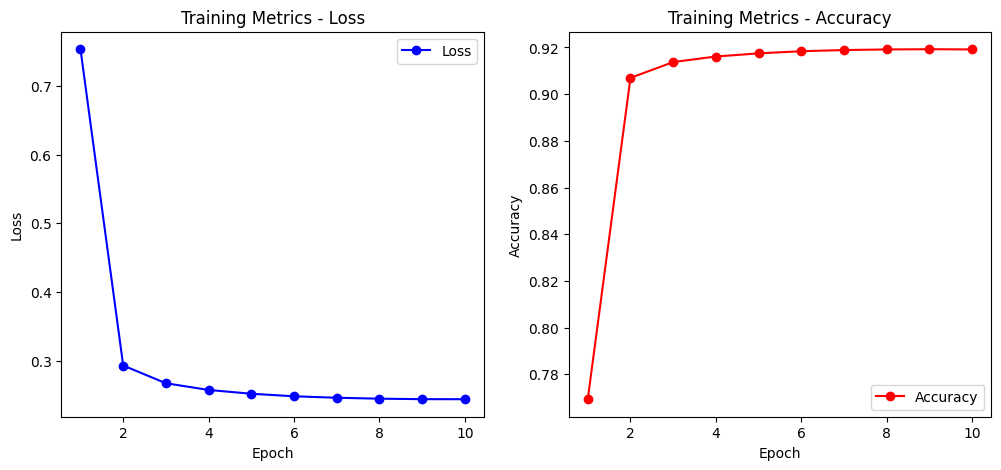

In [227]:
lyrics_path2 = "C:\\Users\\Ananya\\anaconda3\\Dissertation - UL\\Music-Generation-with-AI-1\\Project\\data\\One_Direction_cleaned_lyrics.parquet"
oxford_path2 = "C:\\Users\\Ananya\\anaconda3\\Dissertation - UL\\Music-Generation-with-AI-1\\Project\\data\\The_Oxford_3000.txt"
model_save_path2 = "C:\\Users\\Ananya\\anaconda3\\Dissertation - UL\\Music-Generation-with-AI-1\\Project\\lstm_model_lyrics_generation_oxford3000.pth"


text_i2 = load_combined_data(lyrics_path2, oxford_path2)
dataset2 = LyricsDataset(text_i2)
dataloader2 = DataLoader(dataset2, batch_size=64, shuffle=True)

model2 = LSTMModel(len(dataset2.char_to_int) + 1).to(device)
losses2, accuracies2 = train_model2(model2, dataloader2, epochs=10, lr=0.002)


plot_metrics(losses2, accuracies2)


In [228]:
torch.save(model2.state_dict(), model_save_path2)
print("Model saved successfully.")

Model saved successfully.


In [229]:
user_input = input("Enter the starting words of the song: ")
diversities = [0.04, 0.1, 0.2, 0.5, 1.0, 1.2, 1.5]
final_lyrics2 = generate_and_distribute_lyrics(model2, user_input, dataset2.int_to_char, dataset2.char_to_int, 500, diversities)

for div, lyrics in final_lyrics2.items():
        save_lyrics2(div, lyrics)
        print(f"Diversity {div}:\n{lyrics}\n")

Diversity 0.04:
Harry:
saw you in blue dress is catching the light in her eyes there is no lies no lies there is

Louis:
no question she is not in a disguise with no way out and a long way down everybody needs someone

Zayn:
around but i cannot hold you too close now through the wire through the wire through the wire through the

Niall:
wire through the wire through the wire through the wire through the wire through the wire through the wire through

Liam:
the wire through the wire through the wire through the wire through the wire through the wire through the wire the wire through the wire through the wire through the wire through the wire through the wire through the wire th



Diversity 0.1:
Harry:
saw you in blue dress is catching the light in her eyes there is no lies no lies there is

Louis:
no question she is not in a disguise with no way out and a long way down everybody needs someone

Zayn:
around but i cannot hold you too close now through the wire through the wire through th

## With Rhyme scheme 

### Model 1


In [161]:
import random

In [230]:

import random

def generate_lyrics_rhyme(model, start_str, int_to_char, char_to_int, total_length, diversity=0.8, device= device):
    model.eval()
    input_indices = [char_to_int.get(char, char_to_int['<unk>']) for char in start_str.lower()]
    input_tensor = torch.tensor([input_indices], dtype=torch.long).to(device)
    text = start_str
    states = model.init_states(1)

    for _ in range(total_length):
        output, states = model(input_tensor, states)
        output_div = output / diversity
        probabilities = softmax(output_div[:, -1, :], dim=1)
        char_id = multinomial(probabilities, 1).item()
        # Use get method with ' ' as default if char_id is not found
        char = int_to_char.get(char_id, ' ')
        text += char
        input_tensor = torch.tensor([[char_id]], dtype=torch.long).to(device)

    return text



    

def generate_and_distribute_lyrics_with_rhyme(model, start_str, int_to_char, char_to_int, total_length, diversities):
    names = ["Harry", "Louis", "Niall", "Zayn", "Liam"]
    random.shuffle(names)  # Randomize singer order
    rhyme_schemes = {
        "AABBA": [names[0], names[3], names[1], names[4], names[2]],
        "ABCDE": names,
        "ABABC": [names[0], names[1], names[2], names[4], names[3]],
        "ABCAD": [names[2], names[1], names[4], names[3], names[0]],
    }
    
    lyrics_with_names = {}
    for diversity in diversities:
        extended_lyrics = generate_lyrics2(model, start_str, int_to_char, char_to_int, total_length, diversity)
        words = np.array(extended_lyrics.split())
        rhyme_scheme, distribution = random.choice(list(rhyme_schemes.items()))
        part_lengths = len(words) // len(distribution)
        parts = [words[i * part_lengths: (i + 1) * part_lengths] for i in range(len(distribution))]

        formatted_text = ""
        for name, part in zip(distribution, parts):
            formatted_text += f"{name}:\n{' '.join(part)}\n\n"

        formatted_text += f"Rhyme Scheme Used: {rhyme_scheme}\n"
        lyrics_with_names[diversity] = formatted_text

    return lyrics_with_names

In [231]:
def save_lyrics_rhyme_model1(div, lyrics, filename="generated_lyrics_rhyme_model1.txt"):
    with open(filename, 'w') as file:
        file.write(lyrics)

In [232]:
def save_lyrics_rhyme_model2(div, lyrics, filename="generated_lyrics_rhyme_model2_Oxford3000.txt"):
    with open(filename, 'w') as file:
        file.write(lyrics)

In [233]:
user_input = input("Enter the starting words of the song: ")
diversities = [0.1, 0.5, 0.8, 1.0, 1.5, 1.8, 2.0, 2.5, 2.8, 3.0]
final_lyrics_rhyme_mod1 = generate_and_distribute_lyrics_with_rhyme(model, user_input, dataset.int_to_char, dataset.char_to_int, 620, diversities)

for div, lyrics in final_lyrics_rhyme_mod1.items():
        save_lyrics_rhyme_model1(div, lyrics)
        print(f"Diversity {div}:\n{lyrics}\n")

Diversity 0.1:
Niall:
saw you in blue dress everything she never had she is showing off driving too fast moon is breaking through her hair she is heading for something

Zayn:
that she will not forget having no regrets is all that she really wants ooh we are only getting older and you have got that one thing

Liam:
get out get out get out of my head so get out get out get out of my head yeah and fall into my arms instead instead

Harry:
but i need that one thing i need that one thing i need that one thing and you have got that one thing get out get out

Louis:
get out of my head so get out get out get out of my head yeah and fall into my arms instead instead but i need that

Rhyme Scheme Used: ABCAD


Diversity 0.5:
Niall:
saw you in blue dress everything she never had she is showing off driving too fast moon is breaking through her hair she is

Zayn:
heading for something that she will not forget having no regrets is all that she really wants ooh we are only getting older baby

Liam:
o

### Model 2 -with Oxford 3000

In [236]:
def generate_lyrics_rhyme2(model, start_str, int_to_char, char_to_int, total_length, diversity=0.8, device= device):
    model.eval()
    input_indices = [char_to_int.get(char, char_to_int['<unk>']) for char in start_str.lower()]
    input_tensor = torch.tensor([input_indices], dtype=torch.long).to(device)
    text = start_str
    states = model.init_states(1)

    for _ in range(total_length):
        output, states = model(input_tensor, states)
        output_div = output / diversity
        probabilities = softmax(output_div[:, -1, :], dim=1)
        char_id = multinomial(probabilities, 1).item()
        # Use get method with ' ' as default if char_id is not found
        char = int_to_char.get(char_id, ' ')
        text += char
        input_tensor = torch.tensor([[char_id]], dtype=torch.long).to(device)

    return text



    

def generate_and_distribute_lyrics_with_rhyme2(model, start_str, int_to_char, char_to_int, total_length, diversities):
    names = ["Harry", "Louis", "Niall", "Zayn", "Liam"]
    random.shuffle(names)  # Randomize singer order
    rhyme_schemes = {
        "AABBA": [names[0], names[3], names[1], names[4], names[2]],
        "ABCDE": names,
        "ABABC": [names[0], names[1], names[2], names[4], names[3]],
        "ABCAD": [names[2], names[1], names[4], names[3], names[0]],
    }
    
    lyrics_with_names = {}
    for diversity in diversities:
        extended_lyrics = generate_lyrics2(model, start_str, int_to_char, char_to_int, total_length, diversity)
        words = np.array(extended_lyrics.split())
        rhyme_scheme, distribution = random.choice(list(rhyme_schemes.items()))
        part_lengths = len(words) // len(distribution)
        parts = [words[i * part_lengths: (i + 1) * part_lengths] for i in range(len(distribution))]

        formatted_text = ""
        for name, part in zip(distribution, parts):
            formatted_text += f"{name}:\n{' '.join(part)}\n\n"

        formatted_text += f"Rhyme Scheme Used: {rhyme_scheme}\n"
        lyrics_with_names[diversity] = formatted_text

    return lyrics_with_names

In [237]:
user_input = input("Enter the starting words of the song: ")
diversities = [0.1, 0.5, 0.8, 1.0, 1.5, 1.8, 2.0, 2.5, 2.8, 3.0]
final_lyrics_rhyme_mod2 = generate_and_distribute_lyrics_with_rhyme2(model2, user_input, dataset2.int_to_char, dataset2.char_to_int, 620, diversities)

for div, lyrics in final_lyrics_rhyme_mod2.items():
        save_lyrics_rhyme_model2(div, lyrics)
        print(f"Diversity {div}:\n{lyrics}\n")

Diversity 0.1:
Zayn:
saw you in blue dress is catching the light in her eyes there is no lies no lies there is no question she is

Niall:
not in a disguise with no way out and a long way down everybody needs someone around but i cannot hold you too close

Louis:
now through the wire through the wire through the wire through the wire through the wire through the wire through the wire through the

Harry:
wire through the wire through the wire through the wire through the wire through the wire through the wire through the wire through the

Liam:
wire through the wire through the wire through the wire through the wire through the wire through the wire through the wire through the

Rhyme Scheme Used: ABABC


Diversity 0.5:
Zayn:
saw you in blue dress is catching the light in her eyes there is no lies no lies there is no question she is

Liam:
not in a disguise with no way out and a long way down everybody needs someone around but i cannot hold you too close

Niall:
now through the wire thro